# Linear Regression with Ridge Regularization

## Useful imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset


In [2]:
# EDIT THE PATH OF THE CSV HERE
HOUSING_PATH = os.path.join(".", "drive", "My Drive", "Colab Notebooks", "AI2",
                           "Project1", "dataset", "HousingData.csv")

def load_housing_data(housing_path=HOUSING_PATH):
  return pd.read_csv(housing_path)

df = load_housing_data(housing_path=HOUSING_PATH)

## Take a look at the dataset

In [3]:
df.head()

,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median House Value
0,0,3.9816,27.0,4.928668,1.122476,3009.0,4.049798,33.73,-117.93,1.795
1,1,3.4531,23.0,4.021339,1.099338,2511.0,1.847682,34.14,-118.13,2.109
2,2,6.3942,4.0,5.681272,1.095774,5613.0,2.176425,37.78,-121.95,3.567
3,3,2.2243,32.0,5.685221,1.009597,1542.0,2.959693,38.69,-121.45,0.892
4,4,3.0217,9.0,5.006324,1.071146,3265.0,2.581028,37.69,-121.04,1.609


In [4]:
# get rid of the "Unnamed: 0" index column
df = df.drop("Unnamed: 0", axis=1)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median House Value
0,3.9816,27.0,4.928668,1.122476,3009.0,4.049798,33.73,-117.93,1.795
1,3.4531,23.0,4.021339,1.099338,2511.0,1.847682,34.14,-118.13,2.109
2,6.3942,4.0,5.681272,1.095774,5613.0,2.176425,37.78,-121.95,3.567
3,2.2243,32.0,5.685221,1.009597,1542.0,2.959693,38.69,-121.45,0.892
4,3.0217,9.0,5.006324,1.071146,3265.0,2.581028,37.69,-121.04,1.609


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              16512 non-null  float64
 1   HouseAge            16512 non-null  float64
 2   AveRooms            16512 non-null  float64
 3   AveBedrms           16512 non-null  float64
 4   Population          16512 non-null  float64
 5   AveOccup            16512 non-null  float64
 6   Latitude            16512 non-null  float64
 7   Longitude           16512 non-null  float64
 8   Median House Value  16512 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median House Value
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.859050,28.592902,5.429562,1.096896,1429.927689,3.055425,35.632512,-119.565484,2.062298
std,1.887126,12.615380,2.552593,0.494423,1149.664255,10.780690,2.133356,1.998334,1.151592
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.562500,18.000000,4.439906,1.006131,785.000000,2.430205,33.930000,-121.790000,1.189000
50%,3.531300,29.000000,5.227757,1.048689,1168.000000,2.814815,34.260000,-118.500000,1.786000
75%,4.725000,37.000000,6.051724,1.099955,1729.000000,3.278159,37.710000,-118.007500,2.646000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.490000,5.000010


Great, we can see that there are no missing values in the dataset

### Plottings to gain insight

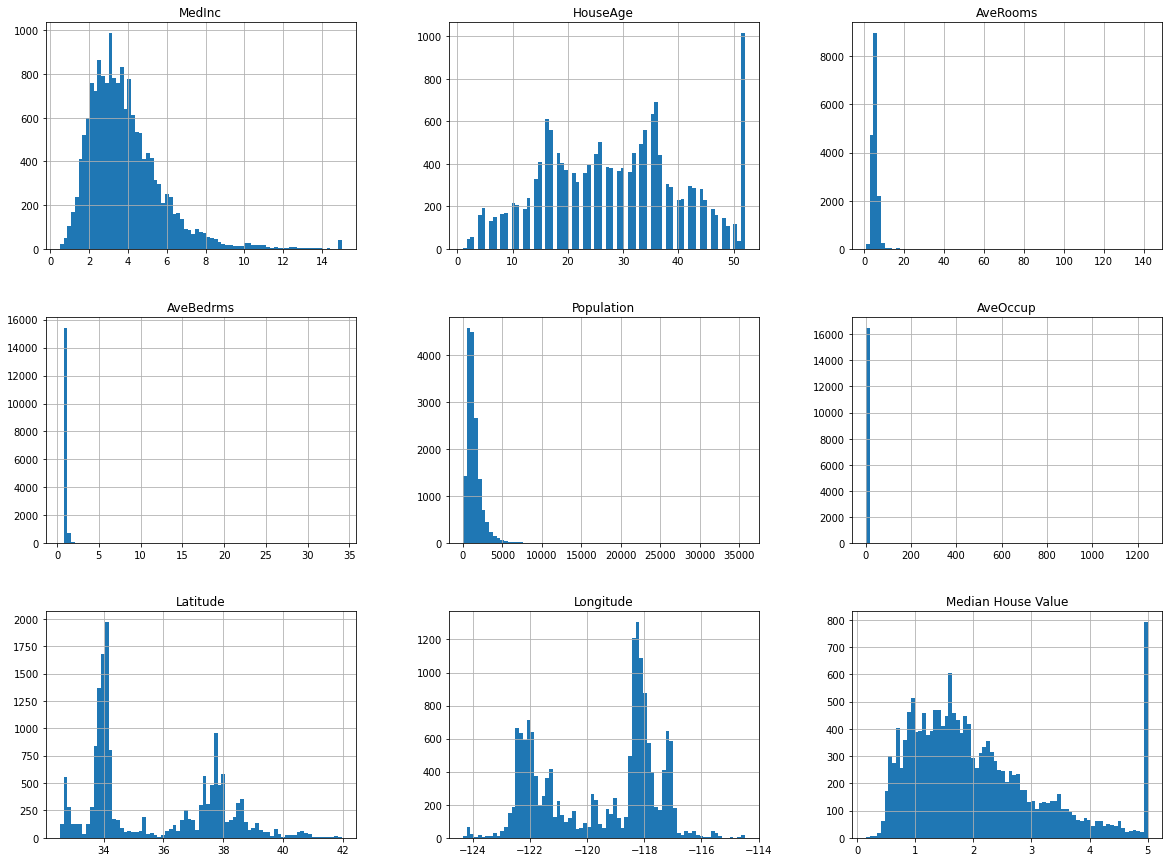

In [7]:
df.hist(bins=75, figsize=(20, 15))
plt.show()

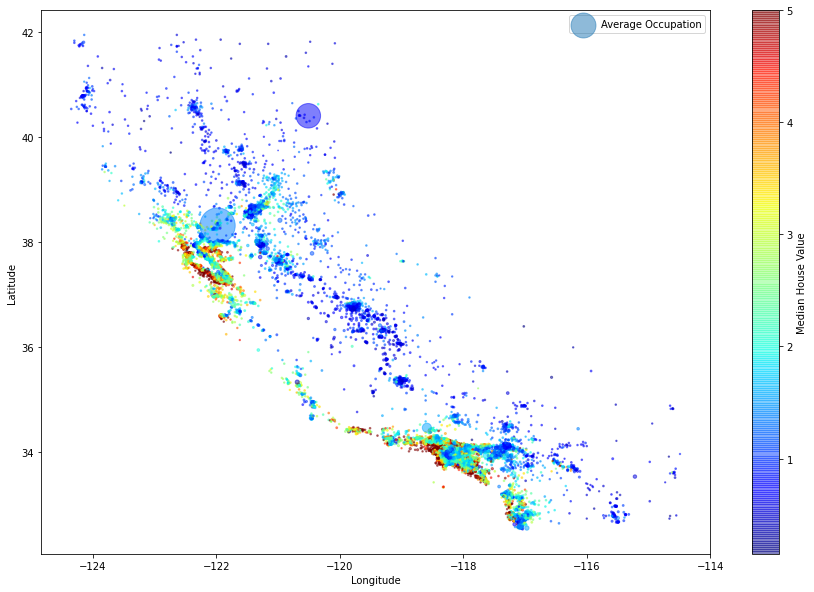

In [8]:
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.5,
        s=df["AveOccup"], label="Average Occupation", figsize=(15,10),
        c="Median House Value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()

## Now we would like to create the sets for training, validation and testing. 
### First let's do some analysis on the data.

In [9]:
# get Pearsons r coefficient
corr_matrix = df.corr()
corr_matrix["Median House Value"].sort_values(ascending=False)

Median House Value    1.000000
MedInc                0.683619
AveRooms              0.148807
HouseAge              0.103891
Population           -0.025447
AveOccup             -0.028013
AveBedrms            -0.040525
Longitude            -0.050616
Latitude             -0.141712
Name: Median House Value, dtype: float64

### We observe that the Median Income is highly correlated with the Median House Value. Let's take a better look.

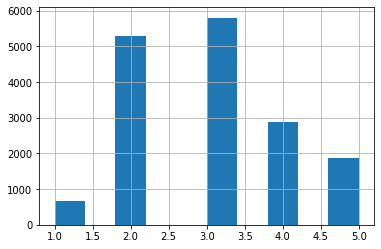

In [10]:
# we have seen that most median incomes appear in the range [1, 6]
df["income_cat"] = pd.cut(df["MedInc"],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()

We can clearly see that there are way more training examples where the Median Income is in the range [1.5, 3.5]. If we split the dataset in a random way and the training set ends up having few instances with Median Income **NOT** in the set [1.5, 3.5], then the sets will be skewed and we will not have good performance in validation and testing. So we must perform a Stratified Splitting of the dataset.

### We can use sklearns StratifiedShuffleSplit() to perform the split.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
# first make a split for training (70%) and validation-testing (30%)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_validation_index in split.split(df, df["income_cat"]):
    train_set = df.iloc[train_index]
    test_validation_set = df.iloc[test_validation_index]

# make another split for validation (15%) and testing (15%)
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, validation_index in split2.split(test_validation_set, test_validation_set["income_cat"]):
    test_set = test_validation_set.iloc[test_index]
    validation_set = test_validation_set.iloc[validation_index]

# now get rid of the "income_cat" column
for set_ in (train_set, validation_set, test_set):
  set_.drop("income_cat", axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
train_set.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median House Value
861,3.0284,25.0,4.240803,0.943144,991.0,3.314381,32.57,-117.06,1.236
8438,3.6250,45.0,4.917808,1.280822,662.0,2.267123,33.96,-118.39,3.294
8580,1.6571,31.0,4.289137,1.078275,1367.0,2.183706,39.15,-123.21,1.089
4100,3.5387,20.0,3.937201,1.090102,4853.0,3.312628,33.73,-117.83,1.604
7116,6.4696,10.0,7.217391,0.971014,1700.0,3.519669,32.97,-117.13,2.495


## Now we have to prepare the data.

First start by creating the appropriate sets

In [14]:
# prepare the training data
x_train = train_set.drop("Median House Value", axis=1)
y_train = train_set["Median House Value"].copy()

# prepare the validation data
x_val = validation_set.drop("Median House Value", axis=1)
y_val = validation_set["Median House Value"].copy()

# prepare the testing data
x_test = test_set.drop("Median House Value", axis=1)
y_test = test_set["Median House Value"].copy()

In [15]:
x_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
11837,3.2857,32.0,5.099338,1.072848,793.0,2.625828,37.62,-122.04
10547,10.9805,52.0,7.658635,1.048193,681.0,2.734940,34.04,-118.41
4065,2.8295,38.0,4.506887,1.006887,3299.0,4.544077,34.05,-118.18
16351,1.9575,24.0,4.528424,1.058140,2098.0,2.710594,36.79,-119.83
10995,3.5417,25.0,7.143275,1.298246,868.0,2.538012,38.96,-119.98
...,...,...,...,...,...,...,...,...
4070,1.4923,31.0,4.592841,1.040268,1193.0,2.668904,40.07,-122.14
6672,2.7153,22.0,4.736246,1.030744,2546.0,4.119741,36.43,-121.32
6806,5.2101,18.0,5.817308,1.055288,1278.0,3.072115,37.08,-122.14
6896,4.4559,21.0,4.778646,1.111979,1038.0,2.703125,33.81,-118.19


Now scale the data to have mean 0 ($\mu = 0$) and standard deviation 1 ($\sigma = 1$)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

# scale the data according to the fitting of the training set
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


In [17]:
x_train

array([[-0.43831288, -0.28202433, -0.48154374, ...,  0.0545923 ,
        -1.43002028,  1.24830133],
       [-0.12113607,  1.30715109, -0.20503162, ..., -0.12905292,
        -0.77887042,  0.58219414],
       [-1.16735171,  0.1947283 , -0.4618022 , ..., -0.14368081,
         1.65240137, -1.8318184 ],
       ...,
       [ 0.33219392,  1.22769232,  0.07538513, ..., -0.08804178,
        -1.37380591,  1.18820143],
       [-0.39801452, -0.83823572,  0.01781263, ..., -0.1202938 ,
         1.36196042, -0.86521172],
       [ 2.41797971, -0.20256555,  0.86220555, ..., -0.07616541,
         1.03404322, -1.3259776 ]])

### Convert DataFrames labels to numpy arrays

In [18]:
y_train = np.reshape(y_train.to_numpy(), (-1, 1))
y_val = np.reshape(y_val.to_numpy(), (-1, 1))
y_test = np.reshape(y_test.to_numpy(), (-1, 1))

## Now that the data has been processed, build the Ridge Regression class.

In [19]:
class RidgeRegression:


  def __init__(self, learning_rate=0.01, _lambda=1):
    self.learning_rate = learning_rate
    self._lambda = _lambda
    self.w = None


  def fit(self, X_train, Y_train, X_val, Y_val, gd_type="mini-batch", iterations=100, batch_size=32, t0=5, t1=50, tolerance=10e-6, verbose=0, plot_curves=False):
    """
    @param X_train: Training set, which is a numpy array of shape m x n
    @param Y_train: Training labels, which is a numpy array of shape m x 1
    @param X_val: Validation set, which is a numpy array
    @param Y_val: Validation labels, which is a numpy array
    @param gd_type: Gradient Descent Type preferred (string).
      Possible values are 1) "batch", 2) "sgd", 3) "mini-batch"
    @param iterations: Int, denoting how many iterations of gradient
      descent to perform
    @param batch_size: The batch size in case the gd_type is "mini-batch"
    @param t0: Hyperparameter used for sgd learning schedule
    @param t1: Hyperparameter used for sgd learning schedule
    @param tolerance: In case of batch gradient descent, it is how much we
      tolerate that the loss diminished (basically it implements Early Stopping)
    @param verbose: Set to 1 if you want the progress of the model to be printed
    @param plot_curves: Flag used to denote whether to plot the Learning curves or not
    """
    m = X_train.shape[0]
    n = X_train.shape[1]
    _X_train = np.concatenate((np.ones((m, 1)), X_train), axis=1)

    m_val = X_val.shape[0]
    _X_val = np.concatenate((np.ones((m_val, 1)), X_val), axis=1)
  
    # initialize the weights
    self.w = np.random.randn(n + 1, 1)

    # determine which gradient descent method to use, and call it
    if gd_type == "batch":
      return self._batch_gradient_descent(_X_train, Y_train, _X_val, Y_val, iterations, tolerance, verbose, plot_curves)
    elif gd_type == "sgd":
      return self._stochastic_gradient_descent(_X_train, Y_train, _X_val, Y_val, t0, t1, iterations, verbose, plot_curves)
    elif gd_type == "mini-batch":
      return self._mini_batch_gradient_descent(_X_train, Y_train, _X_val, Y_val, batch_size, iterations, verbose, plot_curves)
    else:
      print("Wrong input for parameter gd_type (gradient descent type).\n"
            "Possible values are 1) batch, 2) sgd, 3) mini-batch\n")


  def _compute_mae_error(self, m_test, Y_hat, Y_test):
    return (1. / m_test) * np.sum(np.abs(Y_hat - Y_test), axis=0)


  def _compute_mse_loss(self, X, Y):
    m = X.shape[0]
    return (1. / m) * np.sum(np.square((X @ self.w - Y)), axis=0)


  def _compute_ridge_loss(self, X, Y):
    mse = self._compute_mse_loss(X, Y)
    regularization_factor = self._lambda * (1. / 2) * np.sum(np.square(self.w), axis=0)
    return mse + regularization_factor


  def _compute_ridge_gradient(self, X, Y):
    m = X.shape[0]
    mse_grad = (2. / m) * (X.T @ (X @ self.w - Y))
    regularization_grad = self._lambda * np.concatenate((np.zeros((1, 1)), self.w[1:]), axis=0)
    return mse_grad + regularization_grad
      

  def _batch_gradient_descent(self, X_train, Y_train, X_val, Y_val, iterations, tolerance, verbose, plot_curves=False):
    """
    To see what parameters represent, check the comments in the .fit() method
    Note that batch gradient descent has a fixed learning rate parameter,
    might make a schedule later if I don't forget it
    """
    # arrays to store loss functions values in order to plot learning curves later
    train_loss = np.zeros((iterations, 1))
    val_loss = np.zeros((iterations, 1))

    # value to monitor early stopping
    stopped_at_iteration = iterations

    # start the loop for batch gradient descent
    for iteration in range(iterations):
      gradients = self._compute_ridge_gradient(X_train, Y_train)
      self.w -= self.learning_rate * gradients

      train_loss[iteration] = self._compute_ridge_loss(X_train, Y_train)
      val_loss[iteration] = self._compute_mse_loss(X_val, Y_val)

      if verbose:
        print("At iteration {}, Training Loss: {}, Validation Loss: {}".format(iteration, train_loss[iteration], val_loss[iteration]))

      if (tolerance is not None) and (iteration > 0) and (val_loss[iteration - 1] - val_loss[iteration] <= tolerance):
        if verbose:
          print("Stopped training at iteration {} because validation loss started decreasing very slowly\n".format(iteration))
          print("Previous validation loss: {}, current validation loss: {}\n".format(val_loss[iteration - 1], val_loss[iteration]))
        stopped_at_iteration = iteration
        break

    train_loss = train_loss[:stopped_at_iteration]
    val_loss = val_loss[:stopped_at_iteration]

    # plot the learning curves if specified
    if plot_curves:
      self._plot_curves(train_loss, val_loss, "Batch Gradient Descent")

    return train_loss, val_loss


  def _learning_rate_schedule(self, value, t0, t1=50):
    return t0 / (value + t1)


  def _stochastic_gradient_descent(self, X_train, Y_train, X_val, Y_val, t0, t1, iterations, verbose, plot_curves=False):
    """
    To see what parameters represent, check the comments in the .fit() method
    """
    # total training examples
    m = X_train.shape[0]
    # arrays to store loss functions values in order to plot learning curves later
    train_loss = np.zeros((iterations, 1))
    val_loss = np.zeros((iterations, 1))

    # start the loop for stochastic gradient descent
    for iteration in range(iterations):
      for tr_example in range(m):
        random_index = np.random.randint(m)
        xi = np.reshape(X_train[random_index, :], (1, -1))
        yi = np.reshape(Y_train[random_index], (-1, 1))

        gradients = self._compute_ridge_gradient(xi, yi)
        self.learning_rate = self._learning_rate_schedule(iteration * m + tr_example, t0=t0, t1=t1)
        self.w -= self.learning_rate * gradients

      train_loss[iteration] = self._compute_ridge_loss(X_train, Y_train)
      val_loss[iteration] = self._compute_mse_loss(X_val, Y_val)

      if verbose:
        print("At iteration {}, Training Loss: {}, Validation Loss: {}".format(iteration, train_loss[iteration], val_loss[iteration]))

    # plot the learning curves if specified
    if plot_curves:
      self._plot_curves(train_loss, val_loss, "Stochastic Gradient Descent")

    return train_loss, val_loss


  def _mini_batch_gradient_descent(self, X_train, Y_train, X_val, Y_val, batch_size, iterations, verbose, plot_curves=False):
    """
    To see what parameters represent, check the comments in the .fit() method
    """
    # total training examples
    m = X_train.shape[0]
    # arrays to store loss functions values in order to plot learning curves later
    train_loss = np.zeros((iterations, 1))
    val_loss = np.zeros((iterations, 1))

    total_batches = m // batch_size
    if m % batch_size != 0:
      total_batches += 1

    # start the loop for mini batch gradient descent
    for iteration in range(iterations):
      for batch in range(total_batches):
        random_indices = np.random.choice(m, batch_size, replace=False)
        x_batch = X_train[random_indices, :]
        y_batch = Y_train[random_indices]

        gradients = self._compute_ridge_gradient(x_batch, y_batch)
        self.w -= self.learning_rate * gradients

      train_loss[iteration] = self._compute_ridge_loss(X_train, Y_train)
      val_loss[iteration] = self._compute_mse_loss(X_val, Y_val)

      if verbose:
        print("At iteration {}, Training Loss: {}, Validation Loss: {}".format(iteration, train_loss[iteration], val_loss[iteration]))

    # plot the learning curves if specified
    if plot_curves:
      self._plot_curves(train_loss, val_loss, "Mini-Batch Gradient Descent")

    return train_loss, val_loss

  
  def _plot_curves(self, train_loss, val_loss, gd_type):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.plot(train_loss, color='r', label="Training Loss")
    plt.plot(val_loss, color='b', linestyle="--", label="Validation Loss")
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss J(w)')
    plt.title("Learning Curves for " + gd_type)
    plt.show()


  def predict(self, X_test, Y_test):
    m_test = X_test.shape[0]
    _X_test = np.concatenate((np.ones((m_test, 1)), X_test), axis=1)

    Y_hat = _X_test @ self.w
    mae_accuracy = self._compute_mae_error(m_test, Y_hat, Y_test)

    mse_loss = self._compute_mse_loss(_X_test, Y_test)

    return Y_hat, mae_accuracy, mse_loss

## Now try all the 3 different methods and compare them!

### Batch Gradient Descent

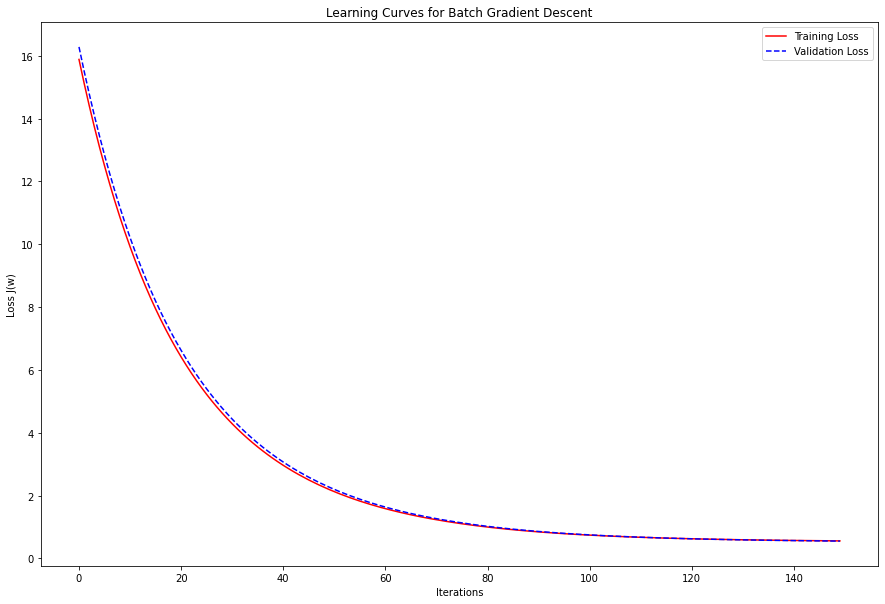

In [20]:
ridge_batch_gd = RidgeRegression(learning_rate=0.01, _lambda=0.001)

train_loss_bgd, val_loss_bgd = ridge_batch_gd.fit(x_train, y_train, x_val, y_val, gd_type="batch", iterations=150, tolerance=10e-8, verbose=0, plot_curves=True)

In [21]:
results_bgd, mae_test_accuracy_bgd, mse_test_loss_bgd = ridge_batch_gd.predict(x_test, y_test)

m_test = y_test.shape[0]
# change 20 with m_test if you want all the predictions to be printed
for test_example in range(20):
  print("Prediction: {}, Actual Value: {}". format(results_bgd[test_example], y_test[test_example]))

print("\nBGD: For the Test set, Mean Absolute Error: {}, Mean Squared Error: {}\n".format(mae_test_accuracy_bgd, mse_test_loss_bgd))

Prediction: [2.02608555], Actual Value: [1.932]
Prediction: [4.59877311], Actual Value: [5.00001]
Prediction: [1.56371653], Actual Value: [1.265]
Prediction: [0.90489047], Actual Value: [0.67]
Prediction: [0.66148864], Actual Value: [1.148]
Prediction: [2.5258408], Actual Value: [1.412]
Prediction: [2.85918666], Actual Value: [2.996]
Prediction: [1.22963967], Actual Value: [0.58]
Prediction: [2.22290191], Actual Value: [2.621]
Prediction: [0.32812789], Actual Value: [0.875]
Prediction: [1.67512199], Actual Value: [2.375]
Prediction: [0.67684331], Actual Value: [0.536]
Prediction: [2.45828638], Actual Value: [1.688]
Prediction: [3.03011426], Actual Value: [3.572]
Prediction: [2.03564631], Actual Value: [2.143]
Prediction: [2.54226026], Actual Value: [2.7]
Prediction: [1.61751366], Actual Value: [1.357]
Prediction: [2.1578654], Actual Value: [2.224]
Prediction: [1.64897072], Actual Value: [1.299]
Prediction: [2.35812133], Actual Value: [3.111]

BGD: For the Test set, Mean Absolute Error:

### Stochastic Gradient Descent

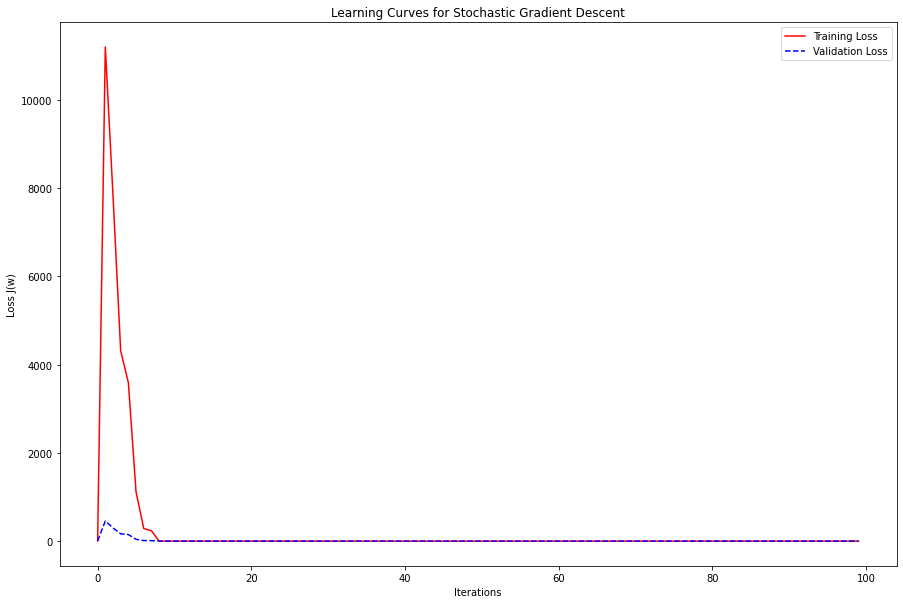

In [22]:
ridge_sgd = RidgeRegression(learning_rate=0.01, _lambda=0.01)

train_loss_sgd, val_loss_sgd = ridge_sgd.fit(x_train, y_train, x_val, y_val, gd_type="sgd", iterations=100, verbose=0, plot_curves=True)

In [23]:
results_sgd, mae_test_accuracy_sgd, mse_test_loss_sgd = ridge_sgd.predict(x_test, y_test)

m_test = y_test.shape[0]
# change 20 with m_test if you want all the predictions to be printed
for test_example in range(20):
  print("Prediction: {}, Actual Value: {}". format(results_sgd[test_example], y_test[test_example]))

print("\nSGD: For the Test set, Mean Absolute Error: {}, Mean Squared Error: {}\n".format(mae_test_accuracy_sgd, mse_test_loss_sgd))

Prediction: [2.1414227], Actual Value: [1.932]
Prediction: [5.18617126], Actual Value: [5.00001]
Prediction: [1.78779481], Actual Value: [1.265]
Prediction: [0.85937905], Actual Value: [0.67]
Prediction: [0.47838192], Actual Value: [1.148]
Prediction: [2.61826992], Actual Value: [1.412]
Prediction: [3.06367664], Actual Value: [2.996]
Prediction: [1.14965247], Actual Value: [0.58]
Prediction: [2.58373149], Actual Value: [2.621]
Prediction: [0.04778357], Actual Value: [0.875]
Prediction: [1.69918555], Actual Value: [2.375]
Prediction: [0.42287718], Actual Value: [0.536]
Prediction: [2.40282019], Actual Value: [1.688]
Prediction: [3.28321999], Actual Value: [3.572]
Prediction: [2.16978739], Actual Value: [2.143]
Prediction: [2.8968328], Actual Value: [2.7]
Prediction: [1.90583252], Actual Value: [1.357]
Prediction: [2.24723295], Actual Value: [2.224]
Prediction: [1.8293381], Actual Value: [1.299]
Prediction: [2.54021548], Actual Value: [3.111]

SGD: For the Test set, Mean Absolute Error: 

### Mini-Batch Gradient Descent

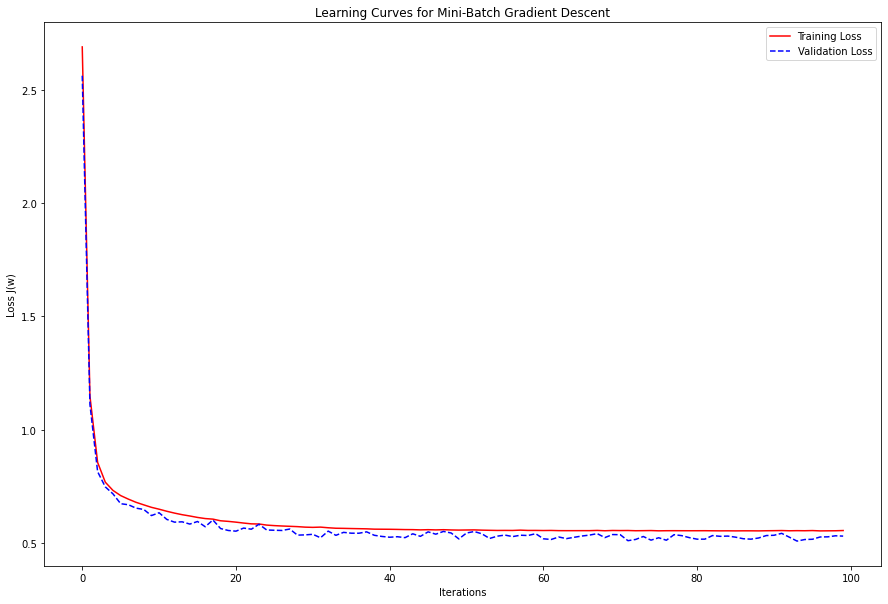

In [24]:
ridge_mbgd = RidgeRegression(learning_rate=0.001, _lambda=0.01)

train_loss_mbgd, val_loss_mbgd = ridge_mbgd.fit(x_train, y_train, x_val, y_val, gd_type="mini-batch", iterations=100, verbose=0, plot_curves=True)

In [25]:
results_mbgd, mae_test_accuracy_mbgd, mse_test_loss_mbgd = ridge_mbgd.predict(x_test, y_test)

m_test = y_test.shape[0]
# change 20 with m_test if you want all the predictions to be printed
for test_example in range(20):
  print("Prediction: {}, Actual Value: {}". format(results_mbgd[test_example], y_test[test_example]))

print("\nMBGD: For the Test set, Mean Absolute Error: {}, Mean Squared Error: {}\n".format(mae_test_accuracy_mbgd, mse_test_loss_mbgd))

Prediction: [2.07740127], Actual Value: [1.932]
Prediction: [5.3862715], Actual Value: [5.00001]
Prediction: [1.77571119], Actual Value: [1.265]
Prediction: [0.90129401], Actual Value: [0.67]
Prediction: [0.74992481], Actual Value: [1.148]
Prediction: [2.73509144], Actual Value: [1.412]
Prediction: [3.10377685], Actual Value: [2.996]
Prediction: [1.13527467], Actual Value: [0.58]
Prediction: [2.58776933], Actual Value: [2.621]
Prediction: [0.18176243], Actual Value: [0.875]
Prediction: [1.76067132], Actual Value: [2.375]
Prediction: [0.5102765], Actual Value: [0.536]
Prediction: [2.40392451], Actual Value: [1.688]
Prediction: [3.33607103], Actual Value: [3.572]
Prediction: [2.09371935], Actual Value: [2.143]
Prediction: [2.87762027], Actual Value: [2.7]
Prediction: [1.718603], Actual Value: [1.357]
Prediction: [2.23903477], Actual Value: [2.224]
Prediction: [1.79229308], Actual Value: [1.299]
Prediction: [2.45035535], Actual Value: [3.111]

MBGD: For the Test set, Mean Absolute Error: 

## As a last touch we can implement some Grid Search functions to fine-tune our models

In [26]:
class GridSearchRidge:


  def __init__(self, x_train, y_train, x_val, y_val):
    self.x_train = x_train
    self.y_train = y_train
    self.x_val = x_val
    self.y_val = y_val


  def perform_grid_search(self, gd_type, hyperparameters):
    """
    @param gd_type: the type of gradient descent
    @param hyperparameters: dictionary with hyperprameters appropriate for each
      gradient descent method
    """

    # determine in which type of gradient descent to perform the grid search
    if gd_type == "batch":
      ridge_models, training_losses, validation_losses = self._bgd_grid_search(hyperparameters)
    elif gd_type == "sgd":
      ridge_models, training_losses, validation_losses = self._sgd_grid_search(hyperparameters)
    elif gd_type == "mini-batch":
      ridge_models, training_losses, validation_losses = self._mbgd_grid_search(hyperparameters)
    else:
      print("Wrong input for parameter gd_type (gradient descent type).\n"
            "Possible values are 1) batch, 2) sgd, 3) mini-batch\n")
      return None
      
    # find the best configuration of hyperparameters
    min_loss = float('inf')
    best_configuration = None

    for key in validation_losses.keys():
      if validation_losses[key][-1] < min_loss:
        min_loss = validation_losses[key][-1]
        best_configuration = key

    # print corresponding message depending on the gradient descent type
    if gd_type == "batch":
      learning_rate = best_configuration[0]
      _lambda = best_configuration[1]
      print("The best configuration of hyperparameters is learning rate = {}, lambda = {}. Validation Loss is {}\n\n".format(learning_rate, _lambda, min_loss))
    
    elif gd_type == "sgd":
      _lambda = best_configuration[0]
      t0 = best_configuration[1]
      t1 = best_configuration[2]
      print("The best configuration of hyperparameters is lambda = {}, t0 = {}, t1 = {}. Validation Loss is {}\n\n".format(_lambda, t0, t1, min_loss))    
    
    else:
      learning_rate = best_configuration[0]
      _lambda = best_configuration[1]
      batch_size = best_configuration[2]
      print("\n\nThe best configuration of hyperparameters is learning rate = {}, lambda = {}, batch_size = {}. Validation Loss is {}\n\n".format(learning_rate, _lambda, batch_size, min_loss))

    self._plot_validation_losses(gd_type, validation_losses, best_configuration)

    return best_configuration, ridge_models[best_configuration], training_losses[best_configuration], validation_losses[best_configuration]


  def _bgd_grid_search(self, hyperparameters):

    learning_rates = hyperparameters["learning_rates"]
    _lambdas = hyperparameters["_lambdas"]
    iterations = hyperparameters.get("iterations", 150)
    tolerance = hyperparameters.get("tolerance", 10e-9)

    # use dictionaries to store information
    ridge_models = {}
    training_losses = {}
    validation_losses = {}

    for lr in learning_rates:
      for _l in _lambdas:
        ridge_models[(lr, _l)] = RidgeRegression(learning_rate=lr, _lambda=_l)
        train_loss, val_loss = ridge_models[(lr, _l)].fit(self.x_train, self.y_train, self.x_val, self.y_val, gd_type="batch", iterations=iterations, tolerance=tolerance)
        training_losses[(lr, _l)] = train_loss
        validation_losses[(lr, _l)] = val_loss

    return ridge_models, training_losses, validation_losses

  
  def _sgd_grid_search(self, hyperparameters):

    learning_rate = hyperparameters.get("learning_rate", 0.001)
    _lambdas = hyperparameters["_lambdas"]
    t0s = hyperparameters["t0"]
    t1s = hyperparameters["t1"]
    iterations = hyperparameters.get("iterations", 100)

    # use dictionaries to store information
    ridge_models = {}
    training_losses = {}
    validation_losses = {}

    for _l in _lambdas:
      for t0 in t0s:
        for t1 in t1s:
          ridge_models[(_l, t0, t1)] = RidgeRegression(learning_rate=learning_rate, _lambda=_l)
          train_loss, val_loss = ridge_models[(_l, t0, t1)].fit(self.x_train, self.y_train, self.x_val, self.y_val, gd_type="sgd", t0=t0, t1=t1, iterations=iterations)
          training_losses[(_l, t0, t1)] = train_loss
          validation_losses[(_l, t0, t1)] = val_loss

    return ridge_models, training_losses, validation_losses


  def _mbgd_grid_search(self, hyperparameters):

    learning_rates = hyperparameters["learning_rates"]
    _lambdas = hyperparameters["_lambdas"]
    batch_sizes = hyperparameters["batch_sizes"]
    iterations = hyperparameters.get("iterations", 100)

    # use dictionaries to store information
    ridge_models = {}
    training_losses = {}
    validation_losses = {}

    for lr in learning_rates:
      for _l in _lambdas:
        for batch_size in batch_sizes:
          ridge_models[(lr, _l, batch_size)] = RidgeRegression(learning_rate=lr, _lambda=_l)
          train_loss, val_loss = ridge_models[(lr, _l, batch_size)].fit(self.x_train, self.y_train, self.x_val, self.y_val, gd_type="mini-batch", batch_size=batch_size, iterations=iterations)
          training_losses[(lr, _l, batch_size)] = train_loss
          validation_losses[(lr, _l, batch_size)] = val_loss

    return ridge_models, training_losses, validation_losses


  def _plot_validation_losses(self, gd_type, validation_losses, best_configuration):
    """
    Plotting method. It can be easily changed to plot preferred attributes.
    """

    all_configurations = list(validation_losses)

    # batch gradient descent
    if gd_type == "batch":

      plt.rcParams['figure.figsize'] = [28, 10]
      learning_rate, _lambda = best_configuration
      
      # keep the configurations with the optimal lambda just for the plot
      target_configurations = [configuration for configuration in all_configurations if configuration[1] == _lambda]
      total_conf = len(target_configurations)

      # use matplotlib for the plots
      f, axes = plt.subplots(nrows=1, ncols=total_conf)
      f.add_subplot(111, frameon=False)
      plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
      plt.xlabel("iterations", fontsize=18)
      plt.ylabel("Loss J(w)", fontsize=18)
      plt.suptitle("Validation Loss for different learning rates (alpha), with fixed regularization parameter lambda = {}".format(_lambda), fontsize=15)

      for i in range(total_conf):
        current_conf = target_configurations[i]
        val_loss = validation_losses[current_conf]

        label = "learning rate = {}".format(current_conf[0])
        axes[i].plot(val_loss, color='b', label=label)
        axes[i].legend()

    # stochastic gradient descent
    elif gd_type == "sgd":

      plt.rcParams['figure.figsize'] = [28, 10]
      _lambda, t0, t1 = best_configuration

      # keep the configurations with optimal t0 and t1 just for the plot
      target_configurations = [configuration for configuration in all_configurations if configuration[1] == t0 and configuration[2] == t1]
      total_conf = len(target_configurations)

      # use matplotlib for the plots
      f, axes = plt.subplots(nrows=1, ncols=total_conf)
      f.add_subplot(111, frameon=False)
      plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
      plt.xlabel("iterations", fontsize=18)
      plt.ylabel("Loss J(w)", fontsize=18)
      plt.suptitle("Validation Loss for different regularization parameters (lambda), with fixed t0 = {} and t1 = {}".format(t0, t1), fontsize=15) 

      for i in range(total_conf):
        current_conf = target_configurations[i]
        val_loss = validation_losses[current_conf]

        label = "lambda = {}".format(current_conf[0])
        axes[i].plot(val_loss, color='r', label=label)
        axes[i].legend()

    # mini batch gradient descent
    else:
      
      plt.rcParams['figure.figsize'] = [28, 10]
      learning_rate, _lambda, batch_size = best_configuration

      # keep the configurations with optimal learning rate and lambda just for the plot
      target_configurations = [configuration for configuration in all_configurations if configuration[0] == learning_rate and configuration[1] == _lambda]
      total_conf = len(target_configurations)

      # use matplotlib for the plots
      f, axes = plt.subplots(nrows=1, ncols=total_conf)
      f.add_subplot(111, frameon=False)
      plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
      plt.xlabel("iterations", fontsize=18)
      plt.ylabel("Loss J(w)", fontsize=18)
      plt.suptitle("Validation Loss for different batch sizes, with fixed learning rate = {} and lambda = {}".format(learning_rate, _lambda), fontsize=15)

      for i in range(total_conf):
        current_conf = target_configurations[i]
        val_loss = validation_losses[current_conf]

        label = "batch size = {}".format(current_conf[2])
        axes[i].plot(val_loss, color='g', label=label)
        axes[i].legend()


### Perform a grid search for every type of gradient descent


In [27]:
# create a GridSearch Object
grid_search = GridSearchRidge(x_train, y_train, x_val, y_val)

Perform Grid Search for Batch Gradient Descent

The best configuration of hyperparameters is learning rate = 0.1, lambda = 0.0001. Validation Loss is [0.51078325]




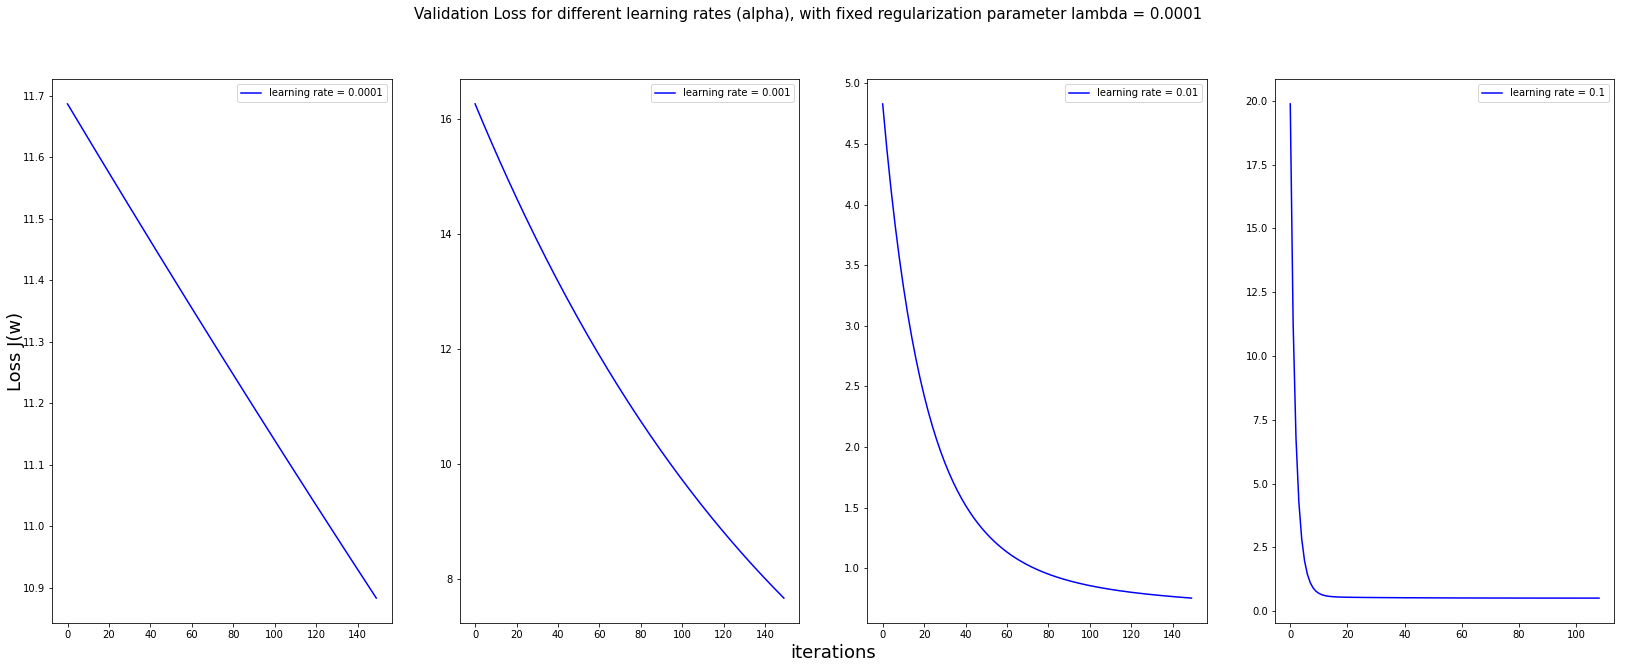

In [28]:
hyperparameters_bgd = {
    "learning_rates": [0.0001, 0.001, 0.01, 0.1],
    "_lambdas": [0.0001, 0.001, 0.01, 0.1, 1]
}

# this will run instantly
result_bgd = grid_search.perform_grid_search(gd_type="batch", hyperparameters=hyperparameters_bgd)

Perform Grid Search for Stochastic Gradient Descent

The best configuration of hyperparameters is lambda = 0.01, t0 = 5, t1 = 100. Validation Loss is [0.51485291]




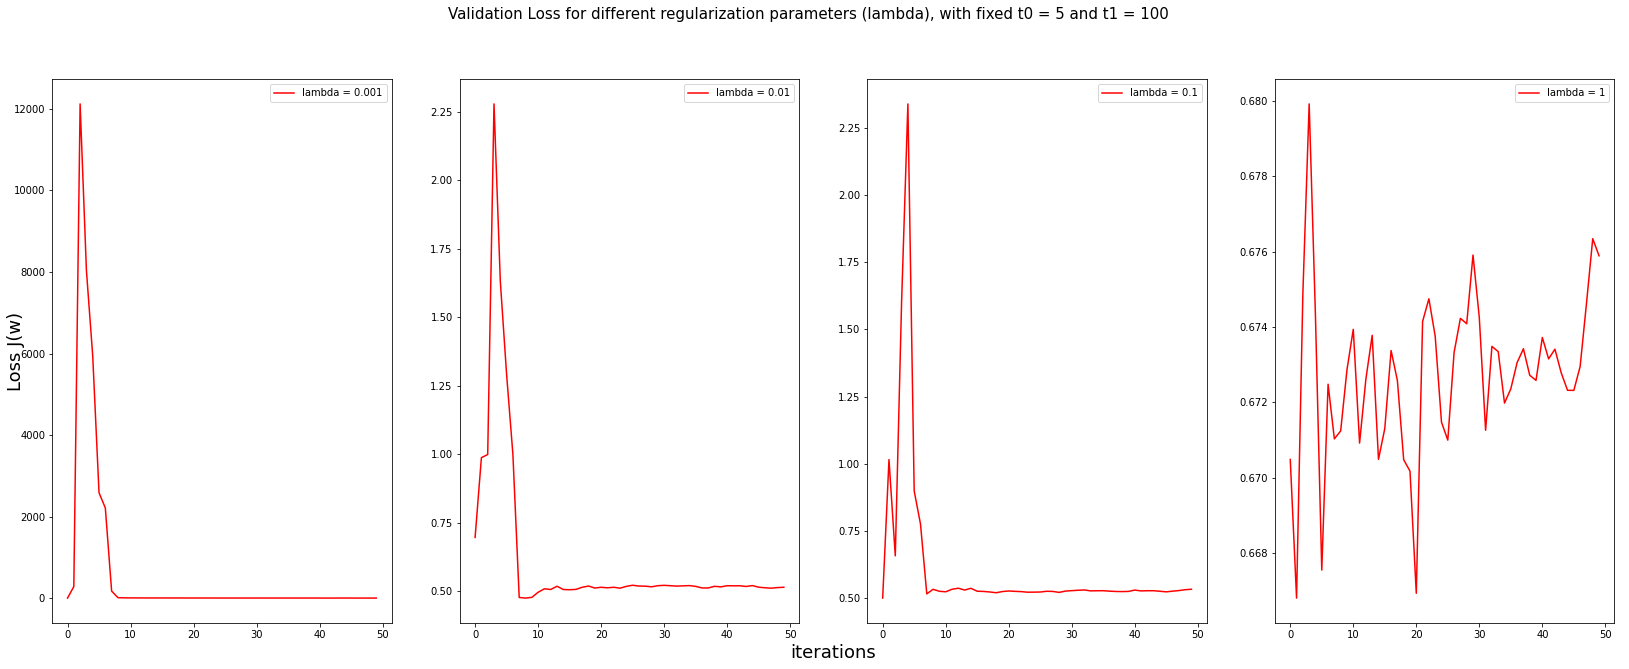

In [29]:
hyperparameters_sgd = {
    "_lambdas": [0.001, 0.01, 0.1, 1],
    "t0": [5, 10],
    "t1": [50, 100],
    "iterations": 50
}

# this will take 4-5 mins to run
result_sgd = grid_search.perform_grid_search(gd_type="sgd", hyperparameters=hyperparameters_sgd)

Perform Grid Search for Mini-Batch Gradient Descent



The best configuration of hyperparameters is learning rate = 0.001, lambda = 0.001, batch_size = 16. Validation Loss is [0.50957544]




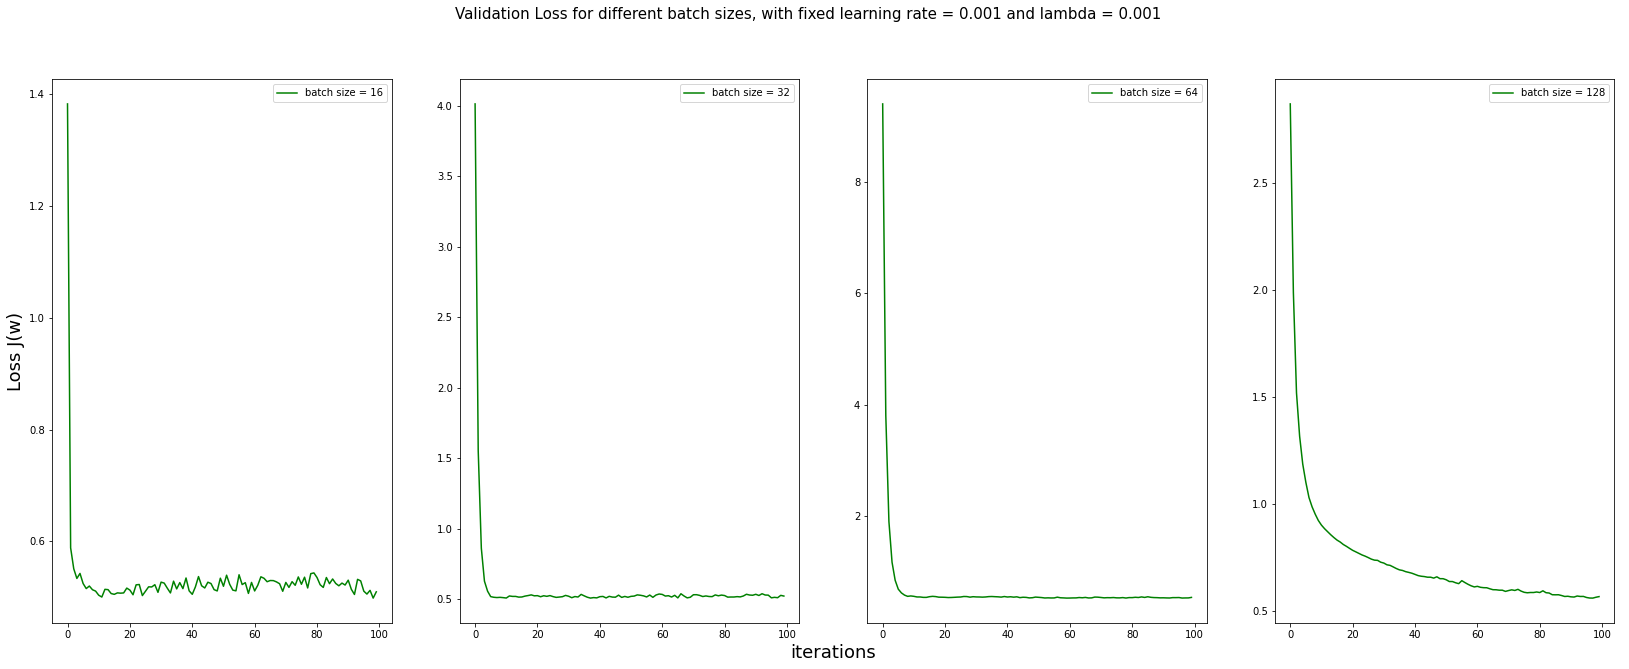

In [30]:
hyperparameters_mbgd = {
    "learning_rates": [0.0001, 0.001, 0.01, 0.1],
    "_lambdas": [0.001, 0.01, 0.1, 1],
    "batch_sizes": [16, 32, 64, 128]
}

# this will take 8-10 mins to run
result_mbgd = grid_search.perform_grid_search(gd_type="mini-batch", hyperparameters=hyperparameters_mbgd)